<a href="https://www.kaggle.com/code/sriusairam/w4-f-chronic-kidney-disease?scriptVersionId=227065251" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 💥 Chronic Kidney Disease

🏆 Problem Statement: Using the data which has 25 features to predict patient with chronic kidney disease

# Generalized code for handling Imbalance and incomplete datasets 


Evaluating for 10% missing values...
Total Refined Datasets Created: 2
Assigned Weights: Minority = 1, Majority = 0.5
Refined Dataset 0: 4 Subspace Classifiers Generated
Refined Dataset 1: 3 Subspace Classifiers Generated
Missing Percentage: 10%
Accuracy: 0.9167
Precision: 0.8846
Recall: 0.9200
F1 Score: 0.9020

Evaluating for 20% missing values...
Total Refined Datasets Created: 2
Assigned Weights: Minority = 1, Majority = 0.5
Refined Dataset 0: 4 Subspace Classifiers Generated
Refined Dataset 1: 3 Subspace Classifiers Generated
Missing Percentage: 20%
Accuracy: 0.8167
Precision: 0.7308
Recall: 0.8261
F1 Score: 0.7755

Evaluating for 30% missing values...
Total Refined Datasets Created: 2
Assigned Weights: Minority = 1, Majority = 0.5
Refined Dataset 0: 3 Subspace Classifiers Generated
Refined Dataset 1: 3 Subspace Classifiers Generated
Missing Percentage: 30%
Accuracy: 0.7500
Precision: 0.7000
Recall: 0.6087
F1 Score: 0.6512

Evaluating for 40% missing values...
Total Refined Datase

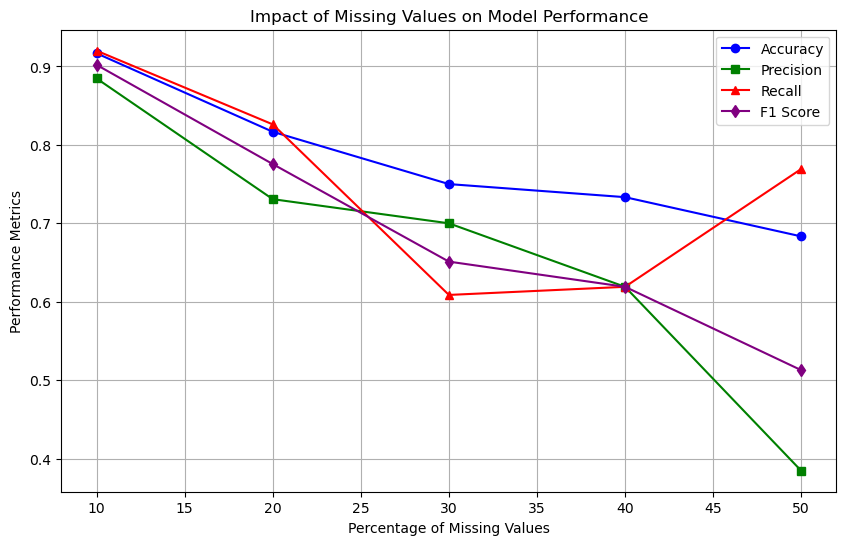

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    
    # Create 2 refined datasets
    majority_partitions = np.array_split(majority_class, 2)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]
    
    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply fixed instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 0.5)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]
    
    # Display the assigned weights
    print(f"Assigned Weights: Minority = 1, Majority = 0.5")
    
    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                print(f"Skipping dataset {dataset_idx}: No data available.")
                break
            
            clf = DecisionTreeClassifier(
                criterion='entropy',
                splitter='best',
                max_depth=6,
                min_samples_split=4,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            )
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='entropy',
                splitter='best',
                max_depth=6,
                min_samples_split=4,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            ).fit(X[selected_features], y)))
            
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        print(f"No classifiers generated for {missing_percentage}% missing values. Skipping evaluation.")
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            print(f"Skipping training for {missing_percentage}% missing values: No valid training data.")
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results for plotting
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display results
        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    except ValueError as e:
        print(f"Error encountered for {missing_percentage}% missing values: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# OLD Experiments 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    imbalance_ratio = len(majority_class) / len(minority_class)

    # Create refined datasets
    num_partitions = int(imbalance_ratio)
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 1 / num_partitions)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None)
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            # Assign unique classifier name
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None
            ).fit(X[selected_features], y)))
            
            # Remove selected features from further iterations
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
    ensemble_clf.fit(X_train, y_train)
    y_pred = ensemble_clf.predict(X_test)

    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store F1 Score for plotting
    f1_scores.append(f1)

    # Display results
    print(f"Missing Percentage: {missing_percentage}%")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Plot F1 score vs. Missing Percentage
plt.figure(figsize=(8, 5))
plt.plot(missing_percents, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Percentage of Missing Values")
plt.ylabel("F1 Score")
plt.title("Impact of Missing Values on F1 Score")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    imbalance_ratio = len(majority_class) / len(minority_class)

    # Create refined datasets
    num_partitions = int(imbalance_ratio)
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]

    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 1 / num_partitions)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None)
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            # Assign unique classifier name
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None
            ).fit(X[selected_features], y)))
            
            # Remove selected features from further iterations
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
    ensemble_clf.fit(X_train, y_train)
    y_pred = ensemble_clf.predict(X_test)

    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store F1 Score for plotting
    f1_scores.append(f1)

    # Display results
    print(f"Missing Percentage: {missing_percentage}%")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Plot F1 score vs. Missing Percentage
plt.figure(figsize=(8, 5))
plt.plot(missing_percents, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Percentage of Missing Values")
plt.ylabel("F1 Score")
plt.title("Impact of Missing Values on F1 Score")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    imbalance_ratio = len(majority_class) / len(minority_class)

    # Create refined datasets
    num_partitions = max(2, int(imbalance_ratio))  # Ensure at least 2 partitions
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]

    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 1 / num_partitions)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                print(f"Skipping dataset {dataset_idx}: No data available.")
                break
            
            clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None)
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            # Assign unique classifier name
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='gini', splitter='best', max_depth=4, random_state=42, max_features=None
            ).fit(X[selected_features], y)))
            
            # Remove selected features from further iterations
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        print(f"No classifiers generated for {missing_percentage}% missing values. Skipping evaluation.")
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            print(f"Skipping training for {missing_percentage}% missing values: No valid training data.")
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results for plotting
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display results
        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    except ValueError as e:
        print(f"Error encountered for {missing_percentage}% missing values: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()


# Hyper Parameter Tuning for better results 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    imbalance_ratio = len(majority_class) / len(minority_class)

    # Create refined datasets
    num_partitions = max(2, int(imbalance_ratio))  # Ensure at least 2 partitions
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]

    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 1 / num_partitions)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                print(f"Skipping dataset {dataset_idx}: No data available.")
                break
            
            clf = DecisionTreeClassifier(
                criterion='entropy',  # Changed from 'gini' to 'entropy' for better splits
                splitter='best',
                max_depth=10,  # Increased depth to improve learning
                min_samples_split=5,  # Ensuring meaningful splits
                min_samples_leaf=2,  # Avoiding overfitting
                class_weight='balanced',  # Handling class imbalance
                random_state=42
            )
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            # Assign unique classifier name
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='entropy',
                splitter='best',
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42
            ).fit(X[selected_features], y)))
            
            # Remove selected features from further iterations
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        print(f"No classifiers generated for {missing_percentage}% missing values. Skipping evaluation.")
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            print(f"Skipping training for {missing_percentage}% missing values: No valid training data.")
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results for plotting
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display results
        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    except ValueError as e:
        print(f"Error encountered for {missing_percentage}% missing values: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# Instance weigting considered

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    Nm = len(minority_class)
    NM = len(majority_class)
    
    # Create refined datasets
    num_partitions = max(2, int(NM / Nm))  # Ensure at least 2 partitions
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]

    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1/Nm if x == 1 else 1/NM)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                print(f"Skipping dataset {dataset_idx}: No data available.")
                break
            
            clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10, min_samples_split=5, 
                                         min_samples_leaf=2, random_state=42, max_features=None)
            clf.fit(X, y, sample_weight=dataset['weights'])
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            # Assign unique classifier name
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='entropy', splitter='best', max_depth=10, min_samples_split=5, 
                min_samples_leaf=2, random_state=42, max_features=None
            ).fit(X[selected_features], y, sample_weight=dataset['weights'])))
            
            # Remove selected features from further iterations
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        print(f"No classifiers generated for {missing_percentage}% missing values. Skipping evaluation.")
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            print(f"Skipping training for {missing_percentage}% missing values: No valid training data.")
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results for plotting
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display results
        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    except ValueError as e:
        print(f"Error encountered for {missing_percentage}% missing values: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()


# Displaying Instance weighting and hyper parameter tuning 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    Nm = len(minority_class)
    NM = len(majority_class)

    # Compute instance weights
    wm = 1 / Nm if Nm > 0 else 0
    wM = 1 / NM if NM > 0 else 0
    print(f"Instance Weights - Minority: {wm:.4f}, Majority: {wM:.4f}")

    # Create refined datasets
    num_partitions = max(2, int(NM / Nm)) if Nm > 0 else 1
    majority_partitions = np.array_split(majority_class, num_partitions)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]
    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: wm if x == 1 else wM)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]

    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                break
            
            clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=6, min_samples_split=4, 
                                         min_samples_leaf=2, class_weight='balanced', random_state=42)
            clf.fit(X, y, sample_weight=dataset['weights'])
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break
            
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='entropy', splitter='best', max_depth=6, min_samples_split=4,
                min_samples_leaf=2, class_weight='balanced', random_state=42
            ).fit(X[selected_features], y, sample_weight=dataset['weights'])))
            
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    
    except ValueError as e:
        print(f"Error encountered: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# Proper Division of dataset in to refined datasets and instance weights assigned 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df_original = pd.read_csv('/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv')  # Update path accordingly

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data = data.copy()
    total_values = data.size
    missing_count = int((missing_percentage / 100) * total_values)
    indices = np.random.choice(data.size, missing_count, replace=False)
    flat_data = data.values.flatten()
    flat_data[indices] = np.nan
    return pd.DataFrame(flat_data.reshape(data.shape), columns=data.columns)

# Store results for different percentages of missing values
missing_percents = [10, 20, 30, 40, 50]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over different missing percentages
for missing_percentage in missing_percents:
    print(f"\nEvaluating for {missing_percentage}% missing values...")

    # Introduce missing values
    df = introduce_missing_values(df_original, missing_percentage)
    
    # Fill missing values with 0
    df.fillna(0, inplace=True)

    # Splitting majority and minority classes
    majority_class = df[df['class'] == 0]
    minority_class = df[df['class'] == 1]
    
    # Create 2 refined datasets
    majority_partitions = np.array_split(majority_class, 2)
    refined_datasets = [pd.concat([minority_class, part]) for part in majority_partitions]
    
    print(f"Total Refined Datasets Created: {len(refined_datasets)}")

    # Apply fixed instance weighting
    def assign_weights(dataset):
        dataset['weights'] = dataset['class'].apply(lambda x: 1 if x == 1 else 0.5)
        return dataset

    refined_datasets = [assign_weights(rd) for rd in refined_datasets]
    
    # Display the assigned weights
    print(f"Assigned Weights: Minority = 1, Majority = 0.5")
    
    # Generate subspace classifiers
    def generate_subspace_classifiers(dataset, dataset_idx):
        classifiers = []
        features = dataset.drop(columns=['class', 'weights']).columns.tolist()
        clf_count = 0  # Track classifier index

        while features:
            X = dataset[features]
            y = dataset['class']
            
            if X.empty or y.empty:
                print(f"Skipping dataset {dataset_idx}: No data available.")
                break
            
            clf = DecisionTreeClassifier(
                criterion='entropy',
                splitter='best',
                max_depth=6,
                min_samples_split=4,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            )
            clf.fit(X, y)
            selected_features = X.columns[clf.feature_importances_ > 0].tolist()
            
            if not selected_features:
                break  # Stop if no important features are found
            
            classifier_name = f'dt_{dataset_idx}_{clf_count}'
            classifiers.append((classifier_name, DecisionTreeClassifier(
                criterion='entropy',
                splitter='best',
                max_depth=6,
                min_samples_split=4,
                min_samples_leaf=2,
                random_state=42,
                class_weight='balanced'
            ).fit(X[selected_features], y)))
            
            features = [f for f in features if f not in selected_features]
            clf_count += 1

        print(f"Refined Dataset {dataset_idx}: {len(classifiers)} Subspace Classifiers Generated")
        return classifiers

    all_classifiers = []
    for idx, rd in enumerate(refined_datasets):
        all_classifiers.extend(generate_subspace_classifiers(rd, idx))

    if not all_classifiers:
        print(f"No classifiers generated for {missing_percentage}% missing values. Skipping evaluation.")
        continue

    # Ensemble classifier
    ensemble_clf = VotingClassifier(estimators=all_classifiers, voting='soft')
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2)
        
        if X_train.empty or y_train.empty:
            print(f"Skipping training for {missing_percentage}% missing values: No valid training data.")
            continue
        
        ensemble_clf.fit(X_train, y_train)
        y_pred = ensemble_clf.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results for plotting
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display results
        print(f"Missing Percentage: {missing_percentage}%")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    except ValueError as e:
        print(f"Error encountered for {missing_percentage}% missing values: {e}")
        continue

# Plot metrics vs. Missing Percentage
plt.figure(figsize=(10, 6))
plt.plot(missing_percents[:len(f1_scores)], accuracy_scores, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(missing_percents[:len(f1_scores)], precision_scores, marker='s', linestyle='-', label="Precision", color='g')
plt.plot(missing_percents[:len(f1_scores)], recall_scores, marker='^', linestyle='-', label="Recall", color='r')
plt.plot(missing_percents[:len(f1_scores)], f1_scores, marker='d', linestyle='-', label="F1 Score", color='purple')

plt.xlabel("Percentage of Missing Values")
plt.ylabel("Performance Metrics")
plt.title("Impact of Missing Values on Model Performance")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Manual 



# Libraries 📖

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from sklearn.impute import SimpleImputer
import pandas as pd
from numpy import isnan
from sklearn.preprocessing import LabelEncoder
from numpy import nan
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Load data 📁

In [ ]:
df_data=pd.read_csv("../input/ckdisease/kidney_disease.csv")


In [ ]:
df_data

# Data analysis 📊

In [ ]:
df_data.info()

In [ ]:
df_data.head(5)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">📉 Observation
      <li><b>Observation One:</b>All Column Names</b> are not user-friendly.</li>
      <li><b>Observation Two:</b>Following columns values in numeric but reflect as text column
        <ul>
          <li>pcv (packed_cell_volume)</li>
          <li>wc (white_blood_cell_count)</li>
          <li>rc (red_blood_cell_count)</li>
        </ul>
      </li>
</div>

In [ ]:
missing = df_data.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(20)

In [ ]:
# dropping 'id' column
df_data.drop('id', axis = 1, inplace = True)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;"><b>📉 Observation :</b>
    <li><b>Observation Three:</b> Certain columns contain <b>missing data</B> that necessitates our attention and management.</li>
</div>

In [ ]:
print(f"dm :- {df_data['dm'].unique()}")
print(f"cad :- {df_data['cad'].unique()}")
print(f"classification :- {df_data['classification'].unique()}")

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;"><b>📉 Observation :</b>
    <li><b>Observation Four:</b> There are typo errors in dm (diabetes_mellitus), cad (coronary_artery_disease), and classification (class) columns</li>
    <li><b>Observation Five:</b> Need to change all column with Text value to Numeric</li>
</div>

# Preprocessing ⚙️ 

<li><b>Resolving Observation One:</b> Allocate more user-friendly names to the columns</li>

In [ ]:
# Notice the unfriendly column names
df_data.head(3)

In [ ]:
df_data.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'anemia', 'class']

In [ ]:
# Friendly column names allocated
df_data.head(3)

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; margin-top: 15px; background-color: #ffffff00; font-size: 
            100%; text-align: left;">
    <b> 🚩 Column Names renamed successfully</b>
</div>

<li><b>Resolving Observation Two:</b> Converting text columns (packed_cell_volume, white_blood_cell_count and red_blood_cell_count) to numeric format</li>

In [ ]:
# Notice these columns are of datatype Object
text_columns = ['packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']

for column in text_columns:
    print(f"{column} -: {df_data[column].dtype}")

In [ ]:
# Convert text column to numeric column
def convert_text_to_numeric_col (dataframe, feature):
    dataframe[feature] = pd.to_numeric(df_data[feature], errors='coerce')

for column in text_columns:
    convert_text_to_numeric_col(df_data, column)
    print(f"text_columns: {df_data[column].dtype}")

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; margin-top: 15px; background-color: #ffffff00; font-size: 
            100%; text-align: left;">
    <b> 🚩 Column Names (packed_cell_volume, white_blood_cell_count and red_blood_cell_count) converted to numeric successfully</b>
</div>

<li><b>Resolving Observation Three:</b> Resolving missing data</li>

In [ ]:
# Replacing missing values in all numeric columns with mean
'''def mean_value_imputation(dataframe, feature):
    mean_value=dataframe[feature].mean()
    dataframe[feature].fillna(value=mean_value, inplace=True)

# Replacing missing values in all categorical columns with highest frequency data
def impute_mode(dataframe, feature):
    mode = dataframe[feature].mode()[0]
    dataframe[feature] = dataframe[feature].fillna(mode)  '''

In [ ]:
# Obtaining columns names of all numerical features
'''num_columns = [col for col in df_data.columns if df_data[col].dtype != 'object']

# Assigning random number to all missing data in numeric columns
for column_name in num_columns:
    mean_value_imputation(df_data,column_name)'''

In [ ]:
# Obtaining columns names of all categorized features
'''cat_columns = [col for col in df_data.columns if df_data[col].dtype == 'object']
impute_mode(df_data,"blood_pressure")

# Assigning highest frequency to all missing data in categorical columns
for column_name in cat_columns:
    impute_mode(df_data,column_name)'''

In [ ]:
missing = df_data.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(20)

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; margin-top: 15px; background-color: #ffffff00; font-size: 
            100%; text-align: left;">
    <b> 🚩 All missing values have been filled up</b>
</div>

<li><b>Resolving Observation Four:</b> Typo Errors in dm (diabetes_mellitus), cad (coronary_artery_disease), and classification (class) columns</li>

In [ ]:
print(f"diabetes_mellitus :- {df_data['diabetes_mellitus'].unique()}")
print(f"coronary_artery_disease :- {df_data['coronary_artery_disease'].unique()}")
print(f"class :- {df_data['class'].unique()}")

In [ ]:
df_data['diabetes_mellitus'] = df_data['diabetes_mellitus'].replace(to_replace = {' yes':'yes', '\tno':'no', '\tyes':'yes'})
df_data['coronary_artery_disease'] = df_data['coronary_artery_disease'].replace(to_replace = '\tno', value='no')
df_data['class'] = df_data['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [ ]:
print(f"diabetes_mellitus'] :- {df_data['diabetes_mellitus'].unique()}")
print(f"coronary_artery_disease :- {df_data['coronary_artery_disease'].unique()}")
print(f"class :- {df_data['class'].unique()}")

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; margin-top: 15px; background-color: #ffffff00; font-size: 
            100%; text-align: left;">
    <b> 🚩 All typo errors for the three columns rectified</b>
</div>

<li><b>Resolving Observation Five:</b> Feature Encoding - Need to change all column with Text value to Numeric</li>

In [ ]:
df_data['class'] = df_data['class'].map({'ckd': 1, 'not ckd': 0})
df_data['red_blood_cells'] = df_data['red_blood_cells'].map({'normal': 1, 'abnormal': 0})
df_data['pus_cell'] = df_data['pus_cell'].map({'normal': 1, 'abnormal': 0})
df_data['pus_cell_clumps'] = df_data['pus_cell_clumps'].map({'present': 1, 'notpresent': 0})
df_data['bacteria'] = df_data['bacteria'].map({'present': 1, 'notpresent': 0})
df_data['hypertension'] = df_data['hypertension'].map({'yes': 1, 'no': 0})
df_data['diabetes_mellitus'] = df_data['diabetes_mellitus'].map({'yes': 1, 'no': 0})
df_data['coronary_artery_disease'] = df_data['coronary_artery_disease'].map({'yes': 1, 'no': 0}) 
df_data['appetite'] = df_data['appetite'].map({'good': 1, 'poor': 0})
df_data['peda_edema'] = df_data['peda_edema'].map({'yes': 1, 'no': 0})
df_data['anemia'] = df_data['anemia'].map({'yes': 1, 'no': 0})

In [ ]:
for column in text_columns:
    convert_text_to_numeric_col(df_data, column)

In [ ]:
df_data.head()

In [ ]:
df_data.to_csv('newmodifieddataset.csv')

In [ ]:
df_data

In [ ]:
df_data=pd.read_csv("/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv").iloc[:, 1:]

# Apply EM technique

In [ ]:
pip install impyute

In [ ]:
import impyute as impy

In [ ]:
imputeddata=impy.em(df_data.values, loops=1000)

In [ ]:
df_data=pd.DataFrame(imputeddata) 

In [ ]:
#df_data=df_data.fillna(0)
#df_data.to_csv("newwdata_fi10test17.csv")

In [ ]:
df_data.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'anemia', 'class']

In [ ]:
df_data

In [ ]:
df_data.info()

<div style="border-radius: 10px; border: #ff001c solid; padding: 15px; margin-top: 15px; background-color: #ffffff00; font-size: 
            100%; text-align: left;">
    <b> 🚩 All columns assigned to numeric</b>
</div>

# Modeling 🪄

## Splitting Dataset

In [ ]:
# Define Class as Target Variable, and the rest as feature variable
X = df_data.drop("class", axis=1)     # everything except 'class' column
y = df_data['class']

# Define the train dataset as 70% and test dataset as 30%
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

# Confirm that the records returned for Train is about 70% and Test is about 30%
print(f"'X' shape: {X_train.shape}")
print(f"'y' shape: {X_test.shape}")

# Apply Smote to balance the samples 

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train == 0)))

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train.shape))

In [ ]:
print("After OverSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train == 0)))

In [ ]:
!pip install wget 

import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

import pandas as pd
import missingno as msno
har = df_data
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}




orig_dataset=df_data.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.99, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 
print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_data["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc5 = DecisionTreeClassifier()
clf_dtc5.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i



y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)




## Training Models

In [ ]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

# SVM
clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train, Y_train)

# KNN
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, Y_train)

# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)


## Model evaluation

In [ ]:
# Printing of Model Evaluation Report
def print_std_model_evaulation_rpt(Y_test, Y_pred):
    print(classification_report(Y_test, Y_pred))
    print(f"mean_absolute_error :- {mean_absolute_error(Y_test,Y_pred)}")
    print(f"mean_absolute_error :- {mean_squared_error(Y_test,Y_pred, squared=False)}")
    cm1 = confusion_matrix(Y_test, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=clf_rand_forest.classes_)
    disp.plot()
    plt.show()
    


### Random Forest

#### Classification Report

In [ ]:
# Random Forest
Y_pred = clf_rand_forest.predict(X_test)
rand_forest_acc = accuracy_score(Y_test, Y_pred)
print_std_model_evaulation_rpt(Y_test, Y_pred)


print(rand_forest_acc)



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
import sklearn.metrics as metrics
#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, Y_pred)

### SVM

#### Classification Report

In [ ]:
from sklearn.svm import SVC
X = df_data.drop("class", axis=1)     # everything except 'class' column
y = df_data['class']
# Define the train dataset as 70% and test dataset as 30%
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

clf_svm = svm.SVC(kernel='linear') #0.97
# clf_svm = SVC(gamma='auto') # 0.59
# clf_svm = SVC(kernel='poly') # 0.59
# clf_svm = SVC(kernel='rbf',gamma=0.01) # 0.59
# clf_svm.fit(X_test,Y_test)
clf_svm.fit(X_train, Y_train)

Y_pred = clf_svm.predict(X_test)
svm_acc = accuracy_score(Y_test, Y_pred)
print_std_model_evaulation_rpt(Y_test, Y_pred)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
import sklearn.metrics as metrics
#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, Y_pred)

In [ ]:
### KNN
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, Y_train)
Y_pred = clf_knn.predict(X_test)
knn_acc = accuracy_score(Y_test, Y_pred)
print_std_model_evaulation_rpt(Y_test, Y_pred)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
import sklearn.metrics as metrics
#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, Y_pred)

In [ ]:
### Decision Tree
Y_pred = clf_dtc.predict(X_test)
dtc_acc = accuracy_score(Y_test, Y_pred)
print_std_model_evaulation_rpt(Y_test, Y_pred)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
import sklearn.metrics as metrics
#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, Y_pred)

In [ ]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'KNN Classifier', 'Decision Tree Classifier'],
    'Score' : [rand_forest_acc, svm_acc,knn_acc, dtc_acc]
})


sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model',
       title = 'Models Comparison')

fig.show()

In [ ]:
pip install astor


In [ ]:
pip install skompiler


In [ ]:
pip install pydotplus

In [ ]:
X = df_data.drop("class", axis=1)     # everything except 'class' column
y = df_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i

In [ ]:
y_pred = clf_dtc.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Create a subspace classifiers 


In [ ]:
df_data1=pd.read_csv("/kaggle/input/kidney-modified-dataset/Kidney_dataset_Modified.csv").iloc[:, 1:]

In [ ]:
df_data1

In [ ]:
df_data1=df_data1.fillna(0)

In [ ]:
columns = ['age','blood_pressure','sugar','red_blood_cells ',
'pus_cell','pus_cell_clumps','bacteria','blood_glucose_random','blood_urea','potassium','white_blood_cell_count','red_blood_cell_count','hypertension','coronary_artery_disease','peda_edema','class']
data2 = pd.DataFrame(df_data1, columns=columns)
data2

In [ ]:
data2=data2.fillna(0)

In [ ]:
X = data2.drop("class", axis=1)     # everything except 'class' column
y = data2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc2 = DecisionTreeClassifier()
clf_dtc2.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i

In [ ]:
y_pred = clf_dtc2.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Modified Dataset -2

In [ ]:
columns = ['specific_gravity','albumin','serum_creatinine','sodium',
'haemoglobin','packed_cell_volume','diabetes_mellitus','appetite','anemia','age','blood_pressure','red_blood_cells','pus_cell','pus_cell_clumps','bacteria','coronary_artery_disease','class']
data3 = pd.DataFrame(df_data1, columns=columns)
data3


In [ ]:
data3=data3.fillna(0)

X = data3.drop("class", axis=1)     # everything except 'class' column
y = data3['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc3 = DecisionTreeClassifier()
clf_dtc3.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc3, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i








In [ ]:
y_pred = clf_dtc3.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)


# Modified Datast 3


In [ ]:
columns = ['specific_gravity','appetite','anemia','age',
'blood_pressure','red_blood_cells','pus_cell','pus_cell_clumps ','bacteria','coronary_artery_disease  ','blood_pressure','red_blood_cells','pus_cell','pus_cell_clumps','bacteria','coronary_artery_disease','class']
data4 = pd.DataFrame(df_data1, columns=columns)
data4


In [ ]:
data4=data4.fillna(0)

X = data4.drop("class", axis=1)     # everything except 'class' column
y = data4['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc4 = DecisionTreeClassifier()
clf_dtc4.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT3.png')
i=Image(graph.create_png())
i

In [ ]:
y_pred = clf_dtc4.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Modifed Dataset -4

In [ ]:
columns = ['appetite','anemia','pus_cell_clumps ','bacteria','coronary_artery_disease','class']
data5 = pd.DataFrame(df_data1, columns=columns)
data5

In [ ]:
data5=data5.fillna(0)

X = data5.drop("class", axis=1)     # everything except 'class' column
y = data5['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc5 = DecisionTreeClassifier()
clf_dtc5.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i

In [ ]:
y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Save the  models


In [ ]:
import pickle
#pickle.dump(clf_dtc2, open('clf_dtc2', 'wb'))
clf_dtc2 = pickle.load(open('clf_dtc2', 'rb'))
#pickled_model.predict(X_test)



In [ ]:
import pickle
#pickle.dump(clf_dtc3, open('clf_dtc3', 'wb'))
clf_dtc3 = pickle.load(open('clf_dtc3', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
#pickle.dump(clf_dtc4, open('clf_dtc4', 'wb'))
clf_dtc4 = pickle.load(open('clf_dtc4', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
#pickle.dump(clf_dtc5, open('clf_dtc5', 'wb'))
clf_dtc5 = pickle.load(open('clf_dtc5', 'rb'))
#pickled_model.predict(X_test)

# Now form a Ensemble Classifier 

In [ ]:
df_data1

In [ ]:
orig_dataset=df_data1.drop('class',axis=1)
orig_dataset

# Generate diffe missing values 

In [ ]:
!pip install wget 

import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [ ]:
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


In [ ]:
def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}

In [ ]:
har1_miss_mar = produce_NA(har1=har1, p_miss=0.10, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata


In [ ]:
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_data1["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))


'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

# **for 20% missing values**


In [ ]:
har1_miss_mar = produce_NA(har1=har1, p_miss=0.20, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_data1["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))


'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)





# for 30% 

In [ ]:
har1_miss_mar = produce_NA(har1=har1, p_miss=0.30, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_data1["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))


'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)





# For 40%

In [ ]:
har1_miss_mar = produce_NA(har1=har1, p_miss=0.40, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_data1["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))


'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)





# For 50%

In [ ]:
har1_miss_mar = produce_NA(har1=har1, p_miss=0.50, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_data1["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))


'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)





# Evaluate the DT performance on 10 to 50% of Missing Values 


In [ ]:
orig_dataset=df_data1.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.50, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_data1["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtc5 = DecisionTreeClassifier()
clf_dtc5.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtc5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoT1.png')
i=Image(graph.create_png())
i



y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

**

# Other Classifiers - Performance 

# 1. SVC

In [ ]:
orig_dataset=df_data1.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.50, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_data1["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)

clf_dtc5 = svm.SVC(kernel='linear')
clf_dtc5.fit(X_train, y_train)

#clf_dtc5 = DecisionTreeClassifier()
#clf_dtc5.fit(X_train, y_train)

feature_cols = list(X) 




y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# KNN -Classifier 

In [ ]:
orig_dataset=df_data1.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.50, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_data1["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)

clf_dtc5 = KNeighborsClassifier(n_neighbors=5)
clf_dtc5.fit(X_train, y_train)

#clf_dtc5 = DecisionTreeClassifier()
#clf_dtc5.fit(X_train, y_train)

feature_cols = list(X) 




y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Random Forest 

In [ ]:
orig_dataset=df_data1.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.10, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_data1["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)

clf_dtc5 = RandomForestClassifier()
clf_dtc5.fit(X_train, y_train)

#clf_dtc5 = DecisionTreeClassifier()
#clf_dtc5.fit(X_train, y_train)

feature_cols = list(X) 




y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Create aSecond Balanced Dataset for exploring the same 


In [ ]:
df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


X = df_datab2.drop("class", axis=1)     # everything except 'class' column
y = df_datab2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb21 = DecisionTreeClassifier()
clf_dtcb21.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb21, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb21.png')
i=Image(graph.create_png())
i









In [ ]:
y_pred = clf_dtcb21.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Create a modified Dataset 

In [ ]:
columns = ['age','blood_pressure','specific_gravity','albumin','sugar',' red_blood_cells','pus_cell','pus_cell_clumps','bacteria','blood_urea',' serum_creatinine ','potassium ','white_blood_cell_count','red_blood_cell_count ','hypertension','diabetes_mellitus ','coronary_artery_disease',' appetite ','anemia','class']
datab21 = pd.DataFrame(df_datab2, columns=columns)
datab21
datab21=datab21.fillna(0)

X = datab21.drop("class", axis=1)     # everything except 'class' column
y = datab21['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb22 = DecisionTreeClassifier()
clf_dtcb22.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb22, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb22.png')
i=Image(graph.create_png())
i

In [ ]:

y_pred = clf_dtcb22.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Modified Dataset 

In [ ]:
columns = ['sugar',' red_blood_cells','pus_cell','pus_cell_clumps','bacteria','blood_urea',' serum_creatinine ','potassium ','red_blood_cell_count ','diabetes_mellitus ','coronary_artery_disease',' appetite ','anemia','class']
datab22 = pd.DataFrame(df_datab2, columns=columns)
datab22
datab22=datab22.fillna(0)

X = datab22.drop("class", axis=1)     # everything except 'class' column
y = datab22['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb23 = DecisionTreeClassifier()
clf_dtcb23.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb23, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb23.png')
i=Image(graph.create_png())
i









In [ ]:
y_pred = clf_dtcb23.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Modified Dataset 


In [ ]:
columns = [' red_blood_cells','bacteria',' serum_creatinine ',
           'potassium ','red_blood_cell_count ','diabetes_mellitus ',
           'coronary_artery_disease',' appetite ','class']
datab23 = pd.DataFrame(df_datab2, columns=columns)
datab23
datab23=datab23.fillna(0)

X = datab23.drop("class", axis=1)     # everything except 'class' column
y = datab23['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb24 = DecisionTreeClassifier()
clf_dtcb24.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb24, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb23.png')
i=Image(graph.create_png())
i

In [ ]:
y_pred = clf_dtcb24.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)


# Modifed dataset 


In [ ]:
columns = ['red_blood_cells',' serum_creatinine ','potassium','red_blood_cell_count ','diabetes_mellitus ', 'appetite ','class']
datab24 = pd.DataFrame(df_datab2, columns=columns)
datab24
datab24=datab24.fillna(0)

X = datab24.drop("class", axis=1)     # everything except 'class' column
y = datab24['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb25 = DecisionTreeClassifier()
clf_dtcb25.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb25, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb23.png')
i=Image(graph.create_png())
i


In [ ]:
y_pred = clf_dtcb25.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)

# Modified Dataset 

In [ ]:
columns = ['serum_creatinine ','red_blood_cell_count ','diabetes_mellitus ','appetite ','class']
datab25 = pd.DataFrame(df_datab2, columns=columns)
datab25
datab25=datab25.fillna(0)

X = datab25.drop("class", axis=1)     # everything except 'class' column
y = datab25['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)
clf_dtcb26 = DecisionTreeClassifier()
clf_dtcb26.fit(X_train, y_train)
feature_cols = list(X) 
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from six imporaccuracy_scoret StringIO
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_dtcb26, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ClassifierIoTb26.png')
i=Image(graph.create_png())
i


As no attributes are considered for DT construction we neglect thme 

# Save B2 Subspace classifiers 

In [ ]:
import pickle
pickle.dump(clf_dtcb21, open('clf_dtcb21', 'wb'))
clf_dtcb21 = pickle.load(open('clf_dtcb21', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
pickle.dump(clf_dtcb22, open('clf_dtcb22', 'wb'))
clf_dtcb22 = pickle.load(open('clf_dtcb22', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
pickle.dump(clf_dtcb23, open('clf_dtcb23', 'wb'))
clf_dtcb23 = pickle.load(open('clf_dtcb23', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
pickle.dump(clf_dtcb24, open('clf_dtcb24', 'wb'))
clf_dtcb24 = pickle.load(open('clf_dtcb24', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
import pickle
pickle.dump(clf_dtcb25, open('clf_dtcb25', 'wb'))
clf_dtcb25 = pickle.load(open('clf_dtcb25', 'rb'))
#pickled_model.predict(X_test)

# Now create a Ensemble classifier for B2 dataset  and test with different percentages of missing values 

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.10, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtcb21))
estimators.append(('c2',clf_dtcb22))
estimators.append(('c3',clf_dtcb23))
estimators.append(('c4',clf_dtcb24))
estimators.append(('c5',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.20, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtcb21))
estimators.append(('c2',clf_dtcb22))
estimators.append(('c3',clf_dtcb23))
estimators.append(('c4',clf_dtcb24))
estimators.append(('c5',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.30, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtcb21))
estimators.append(('c2',clf_dtcb22))
estimators.append(('c3',clf_dtcb23))
estimators.append(('c4',clf_dtcb24))
estimators.append(('c5',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.40, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtcb21))
estimators.append(('c2',clf_dtcb22))
estimators.append(('c3',clf_dtcb23))
estimators.append(('c4',clf_dtcb24))
estimators.append(('c5',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/b2-dataset/B2-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.50, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtcb21))
estimators.append(('c2',clf_dtcb22))
estimators.append(('c3',clf_dtcb23))
estimators.append(('c4',clf_dtcb24))
estimators.append(('c5',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

# Now Lets combine both the balanced datasets EC's and make EC of EC and test with different percentages of missing values 


In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/actual-after-preprocesing-datast/actual-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()


har = df_datab2
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1


def produce_NA(har1, p_miss, mecha="MAR", opt="logistic", p_obs=None, q=None):
    to_torch = torch.is_tensor(har1) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        har1 = har1.astype(np.float32)
        har1 = torch.from_numpy(har1)
    
    if mecha == "MAR" and opt == "logistic":
        mask = MAR_mask(har1, p_miss, p_obs).double()
        print("mask values")
        print(mask)
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(har1, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(har1, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(har1, p_miss).double()
    else:
        mask = (torch.rand(har1.shape) < p_miss).double()
     
    
    har1_nas = har1.clone()
    har1_nas[mask.bool()] = np.nan
    
    
    
    
    return {'har1_init': har1.double(), 'har1_incomp': har1_nas.double(), 'mask': mask}



har1_miss_mar = produce_NA(har1=har1, p_miss=0.40, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil100.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata



from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar

X = Edata10Mar 
y= df_datab2["class"] 
X
feature_cols = list(X) 
y
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, y)





estimators = []
estimators.append(('c1',clf_dtc2))
estimators.append(('c2',clf_dtc3))
estimators.append(('c3',clf_dtc4))
estimators.append(('c4',clf_dtc5))
estimators.append(('c5',clf_dtcb21))
estimators.append(('c6',clf_dtcb22))
estimators.append(('c7',clf_dtcb23))
estimators.append(('c8',clf_dtcb24))
estimators.append(('c9',clf_dtcb25))



'''voting = VotingClassifier(estimators=estimators,voting='hard')
vot_hard=voting.fit(X_train, Y_train)

y_pred=vot_hard.predict(X_test)
print(y_pred)
score=accuracy_score(Y_test,y_pred)
#print("hard voting score %d" % score)
print(score)'''



# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train, Y_train)
y_pred = vot_soft.predict(X_test)
print(y_pred)
# using accuracy_score
sscore = accuracy_score(Y_test, y_pred)
#print("Soft Voting Score % d" % score)
print(sscore)

from sklearn.metrics import classification_report

#print(classification_report(Y_test, y_pred))
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(Y_test, y_pred)

# Now apply other classifiers on the actual data 

In [ ]:
import pandas as pd
import missingno as msno

df_datab2=pd.read_csv("/kaggle/input/actual-after-preprocesing-datast/actual-newmodifieddataset.csv").iloc[:, 1:]

df_datab2=df_datab2.fillna(0)

df_datab2.info()

orig_dataset=df_datab2.drop('class',axis=1)
orig_dataset
import pandas as pd
import missingno as msno
har = orig_dataset
#har1=har.iloc[:,:-1]
har1=har
#msno.heatmap(har1)
#msno.dendrogram(har1)
har1=har1.values
#print('Shape Test:\t{}\n'.format(har1.shape))
har1


har1=har1.astype(float)
har1

har1_miss_mar = produce_NA(har1=har1, p_miss=0.10, mecha="MAR", p_obs=0.5)
 


#print(har1_mar) 
print(har1_miss_mar['har1_init'])
har1_mar = har1_miss_mar['har1_incomp']
print(har1_mar)  
#har1_mar = pd.DataFrame.from_dict(har1_mar)
R_mcar = har1_miss_mar['mask']
print(R_mcar)
 

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

print(har1_mar)
print('Shape Test:\t{}\n'.format(har1_mar.shape))

import torch
import pandas as pd
import numpy as np

 
x_np = har1_mar.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('10mar_test.csv')

from warnings import filterwarnings
filterwarnings("ignore")

tdf = pd.read_csv("./10mar_test.csv").iloc[:, 1:]
tdf.head()

tdf.shape
# Get null values and dataframe information  check for any missing data in data sets
print('Null Values In DataFrame: {}\n'.format(tdf.isna().sum().sum()))
tdf.info()
tdf=tdf.fillna(0)
tdf.to_csv("data_fil10.csv")

tdf



testdata = pd.read_csv('./10mar_test.csv').iloc[:, 1:] 
 
testdata.head(10)
#testdata=testdata.drop(['16'],axis=1)
testdata

print('Null Values In DataFrame: {}\n'.format(testdata.isna().sum().sum()))
testdata.isnull().sum(0)

testdata=testdata.fillna(0)
testdata
from sklearn.model_selection import train_test_split
#kfold =sklearn.model_selection.KFold(n_splits=10)

import pandas as pd
 
from sklearn.metrics import log_loss
#seed=7
#

# importing voting classifier
from sklearn.ensemble import VotingClassifier
 
    
#Edata10Mar = supp10_data2
Edata10Mar =testdata 
Edata10Mar
X = Edata10Mar  
y= df_datab2["class"] 
X
feature_cols = list(X) 
y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = None)

clf_dtc5 = DecisionTreeClassifier()
clf_dtc5.fit(X_train, y_train)

#clf_dtc5 = DecisionTreeClassifier()
#clf_dtc5.fit(X_train, y_train)

feature_cols = list(X) 




y_pred = clf_dtc5.predict(X_test)
print(y_pred)
def Model_Performance(test,pred):
    #precision = precision_score(test,pred)
    precision = precision_score(test,pred,average='macro')
    recall = recall_score(test,pred,average='macro')
    f1 = f1_score(test,pred,average='macro')
    #print('1. Confusion Matrix:\n',confusion_matrix(test, pred))
    print("\n2. Accuracy Score:", round(accuracy_score(test, pred)*100,2),"%")
    print("3. Precision:", round(precision*100,2),"%")
    print("4. Recall:",round(recall*100,2),"%" )
    print("5. F1 Score:",round(f1*100,2),"%" )
    print("6. clasification report:\n",classification_report(test, pred))
Model_Performance(y_test, y_pred)